Side note: we are evaluating particle level information
maybe we should also do the event level information

In [1]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
print(date)

2024-12-04


In [2]:
!pip install -e ../. --quiet

In [3]:
!pip install --upgrade awkward --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
coffea 0.7.20 requires awkward<2,>=1.5.1, but you have awkward 2.7.1 which is incompatible.


In [4]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [5]:
# read spanet prediction
# spanet_file = "/Users/billyli/UCSD/hhh/reports/bv2/qcd/qcd_finetune_i0_llow_pt.h5"
# s_h5 = h5.File(spanet_file, 'a')

# spanet_file = "/Users/billyli/UCSD/hhh/reports/bv2/qcd/qcd_finetune_i0_llow_pt.h5"
# s_h5 = h5.File(spanet_file, 'a')

spanet_file = "../predictions/qcd_hhh_br_spanet_west.h5"
s_h5 = h5.File(spanet_file, 'a')

# read baseline prediction
# baseline_file = "/Users/billyli/UCSD/hhh/reports/bv2/best_per_week/060524/060524_v4_qcd.h5"
# b_h5 = h5.File(baseline_file)
baseline_file = "../predictions/qcd_chi2_loose_bdt_baseline_predictions_west.h5"
b_h5 = h5.File(baseline_file)

### Reco Boosted

In [6]:
from src.analysis.utils import calc_eff, calc_pur, reset_collision_dp, dp_to_HiggsNumProb

In [7]:
from src.analysis.boosted import sel_pred_bH_by_dp_ap, sel_target_bH_by_mask, gen_pred_bH_LUT, gen_target_bH_LUT

In [8]:
# generate pred/target LUT
# each entry corresponds to [recoH correct or not, reco H pt]
# or 
# [targetH retrieved or not, target H pt]
def get_reco_boosted_h_mass(predfile):
    # Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
    if 'TARGETS' not in predfile.keys():
        predfile["INPUTS"] = predfile["SpecialKey.Inputs"]
        predfile["TARGETS"] = predfile["SpecialKey.Targets"]

    try:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])
    
        # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['detection_probability'])
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['detection_probability'])
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['detection_probability'])

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])
    except:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])+10
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])+10
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])+10
    
         # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')
    
    # collect fatjet pt
    fj_pt = np.array(predfile['INPUTS']['BoostedJets']['fj_pt'])
    
    dps = np.concatenate((dp_bh1.reshape(-1, 1), dp_bh2.reshape(-1, 1), dp_bh3.reshape(-1, 1)), axis=1)
    aps = np.concatenate((ap_bh1.reshape(-1, 1), ap_bh2.reshape(-1, 1), ap_bh3.reshape(-1, 1)), axis=1)

    # convert some arrays to ak array
    bb_ps = np.concatenate((bb_bh1_p.reshape(-1, 1), bb_bh2_p.reshape(-1, 1), bb_bh3_p.reshape(-1, 1)), axis=1)
    bb_ps = ak.Array(bb_ps)
    fj_pt = ak.Array(fj_pt)
    
    # select predictions and targets
    bb_ps_selected = sel_pred_bH_by_dp_ap(dps, aps, bb_ps)
    
    # reconstruct bH to remove overlapped ak4 jets
    fj_eta = np.array(predfile['INPUTS']['BoostedJets']['fj_eta'])
    fj_phi = np.array(predfile['INPUTS']['BoostedJets']['fj_phi'])
    fj_mass = ak.Array(predfile['INPUTS']['BoostedJets']['fj_mass'])
    
    fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D"
    )
    fj_reco = fjs[bb_ps_selected-10]
    
    return fj_mass[bb_ps_selected-10], fj_reco

In [9]:
reco_bh_mass_s, fjs_reco_s = get_reco_boosted_h_mass(s_h5)
reco_bh_mass_b, fjs_reco_b = get_reco_boosted_h_mass(b_h5)

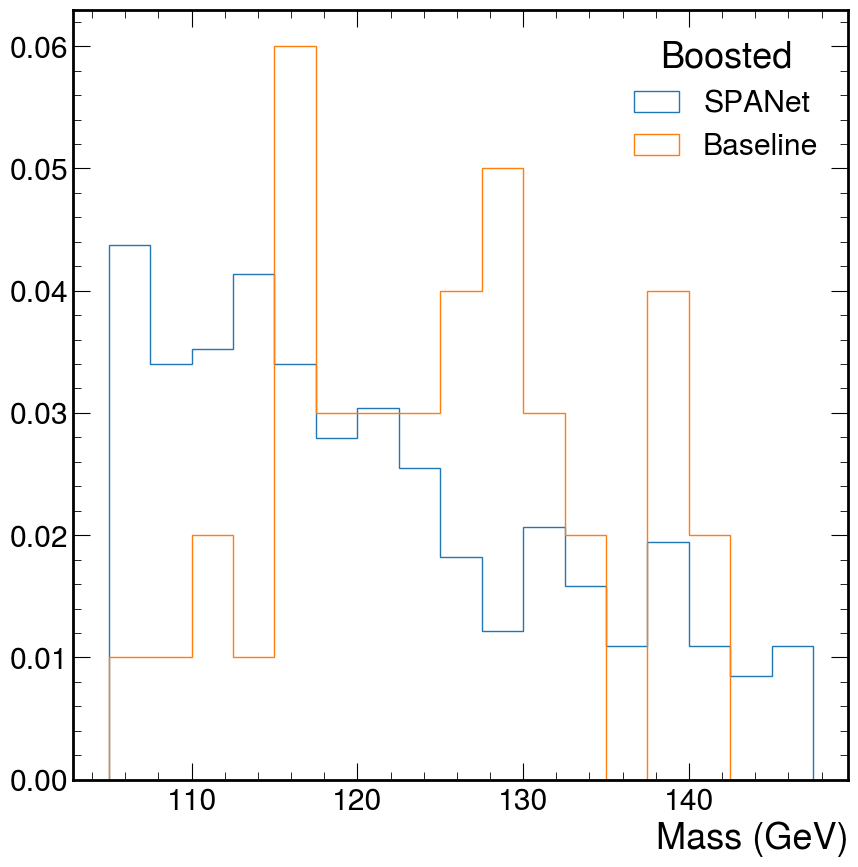

In [10]:
plt.hist(ak.ravel(reco_bh_mass_s), bins=np.arange(105, 150, 2.5), histtype='step', label='SPANet', density=True)
plt.hist(ak.ravel(reco_bh_mass_b), bins=np.arange(105, 150, 2.5), histtype='step', label='Baseline', density=True)
plt.xlabel('Mass (GeV)')
plt.legend(title='Boosted')
plt.show()

In [11]:
from src.analysis.resolved import (
    get_unoverlapped_jet_index,
    sel_pred_h_by_dp_ap,
    sel_target_h_by_mask,
)

In [12]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct_or_not, pt, overlap_w_H_reco, has_boost_H_target, which_H_target]]
@nb.njit
def calc_reco_h_mass(b1_ps_passed, b2_ps_passed, js, goodJetIdx, builder):
    # for each event
    for b1_ps_e, b2_ps_e, jets_e, goodJetIdx_e in zip(b1_ps_passed, b2_ps_passed, js, goodJetIdx):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            if (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                overlap = 0
            else:
                overlap = 1
                continue
                
            predH_mass = (jets_e[b1_p]+jets_e[b2_p]).mass
                    
            builder.append(predH_mass)
        
        builder.end_list()
    return builder

In [13]:
def get_reco_resolved_h_mass(predfile, fjs_reco=None):
    if 'TARGETS' not in predfile.keys():
        predfile["INPUTS"] = predfile["SpecialKey.Inputs"]
        predfile["TARGETS"] = predfile["SpecialKey.Targets"]
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pt = np.array(predfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(predfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(predfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(predfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    # dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    # aps = ak.Array(aps)
    
    dps = reset_collision_dp(dps, aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)

    
    # select predictions and targets
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp_ap(dps, aps, b1_ps, b2_ps)

    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js, dR_min=0.4)
    
    # get reco H mass
    h_mass = calc_reco_h_mass(b1_ps_selected, b2_ps_selected, js, goodJetIdx, ak.ArrayBuilder()).snapshot()
    
    return h_mass

In [14]:
reco_rh_mass_s = get_reco_resolved_h_mass(s_h5, fjs_reco=None)
reco_rh_mass_b = get_reco_resolved_h_mass(b_h5, fjs_reco=None)

Text(1, 0, 'Mass (GeV)')

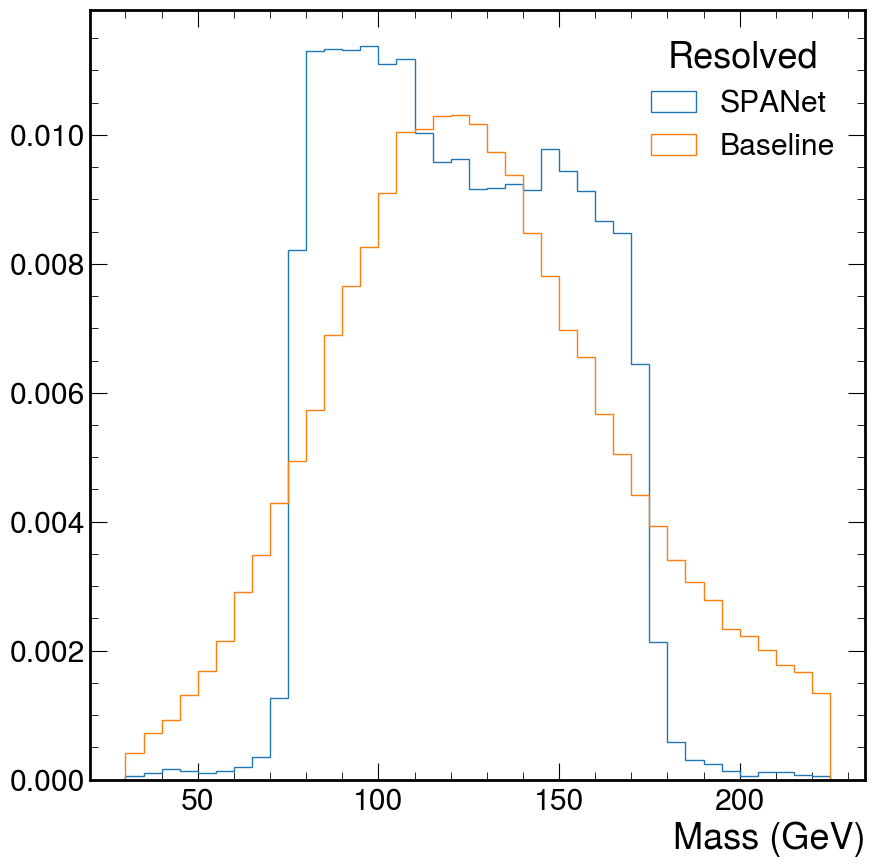

In [15]:
plt.hist(ak.ravel(reco_rh_mass_s), bins=np.arange(30, 230, 5), histtype='step', label='SPANet', density=True)
plt.hist(ak.ravel(reco_rh_mass_b), bins=np.arange(30, 230, 5), histtype='step', label='Baseline', density=True)
plt.legend(title='Resolved')
plt.xlabel('Mass (GeV)')

In [16]:
reco_rh_wOR_mass_s = get_reco_resolved_h_mass(s_h5, fjs_reco=fjs_reco_s)
reco_rh_wOR_mass_b = get_reco_resolved_h_mass(b_h5, fjs_reco=fjs_reco_b)

In [17]:
reco_merged_h_mass_s = ak.ravel(reco_bh_mass_s).tolist() + ak.ravel(reco_rh_wOR_mass_s).tolist()
reco_merged_h_mass_b = ak.ravel(reco_bh_mass_b).tolist() + ak.ravel(reco_rh_wOR_mass_b).tolist()

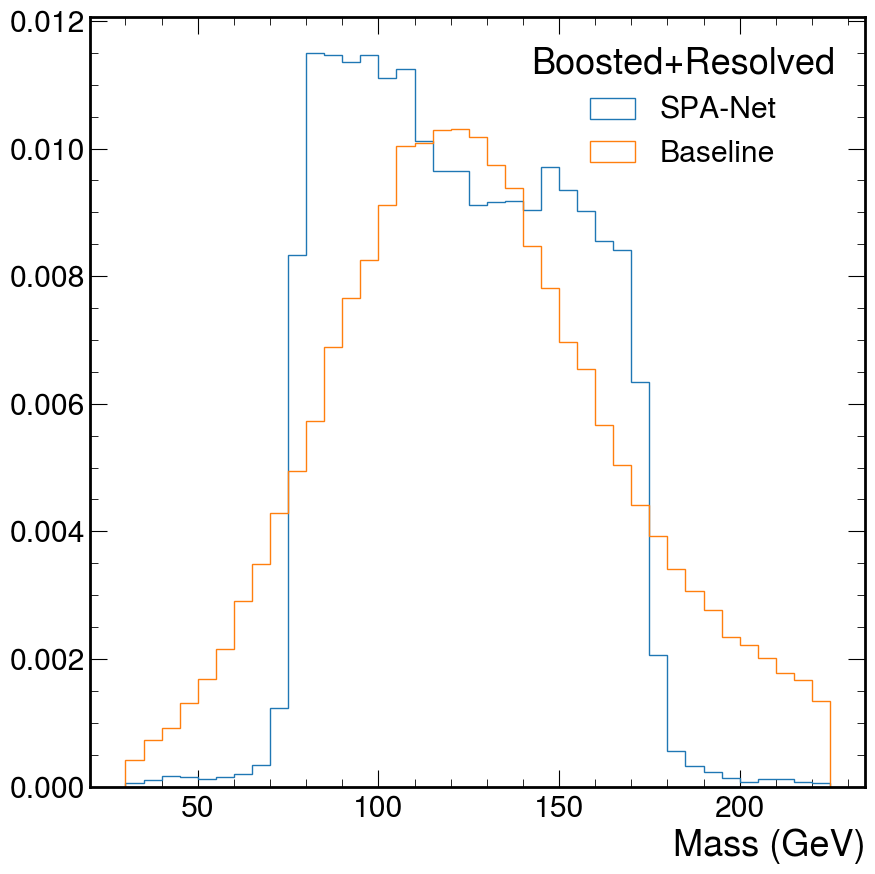

In [18]:
plt.hist(reco_merged_h_mass_s, bins=np.arange(30, 230, 5), histtype='step', label='SPA-Net', density=True)
plt.hist(reco_merged_h_mass_b, bins=np.arange(30, 230, 5), histtype='step', label='Baseline', density=True)
plt.legend(title='Boosted+Resolved')
plt.xlabel('Mass (GeV)')
plt.savefig(f"../plots/HHH/B+R/{date}_mass_sculpting.pdf", format='pdf')